In [1]:
import numpy as np
import wfdb
import _pickle as pickle

CombinedNoise

In [5]:
import wfdb
import numpy as np
import pickle

def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares noise data from the MIT-BIH Noise Stress Test Database (NSTDB) with noise combinations 
    and applies SNR-based adjustments to match the study's acceptable noise range.
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Define acceptable SNR ranges for each noise type
    snr_ranges = {
        "BW": (0, 5),
        "EM": (10, 15),
        "MA": (5, 10)
    }

    # Initialize combined noise storage
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {em_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Define noise combination types (8 combinations as per the study)
        noise_combinations = [
            (0, 0, 0),  # Type 1: No noise
            (1, 0, 0),  # Type 2: BW only
            (0, 1, 0),  # Type 3: EM only
            (0, 0, 1),  # Type 4: MA only
            (1, 1, 0),  # Type 5: BW + EM
            (1, 0, 1),  # Type 6: BW + MA
            (0, 1, 1),  # Type 7: EM + MA
            (1, 1, 1)   # Type 8: BW + EM + MA (all noises)
        ]

        # Create noise matrix
        noise_matrix = np.zeros((bw_noise.shape[0], len(noise_combinations)))
        print(f"[DEBUG] Initialized noise matrix with shape {noise_matrix.shape}")
        
        # Iterate through noise combinations
        for idx, (bw_flag, em_flag, ma_flag) in enumerate(noise_combinations):
            combined_noise_for_type = (
                bw_flag * adjust_snr(bw_noise, snr_ranges["BW"]) +
                em_flag * adjust_snr(em_noise, snr_ranges["EM"]) +
                ma_flag * adjust_snr(ma_noise, snr_ranges["MA"])
            )
            noise_matrix[:, idx] = combined_noise_for_type
            print(f"[DEBUG] Filled noise matrix for combination type {idx+1}, shape: {noise_matrix[:, idx].shape}")
        
        # Append the noise matrix for this channel
        combined_noise.append(noise_matrix)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise_with_SNR.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print('NSTDB noise data with SNR-adjusted combinations saved as pickle')

def adjust_snr(noise, snr_range):
    """
    Adjusts the noise level to match the given SNR range.

    Parameters:
    noise: The original noise signal.
    snr_range: Tuple specifying the desired SNR range (min, max).

    Returns:
    Adjusted noise signal.
    """
    target_snr = np.random.uniform(*snr_range)  # Randomly select SNR from the given range
    signal_power = np.mean(noise**2)
    noise_power = signal_power / (10**(target_snr / 10))
    noise_std = np.sqrt(noise_power)
    
    # Scale the noise to match the target SNR
    adjusted_noise = noise / np.std(noise) * noise_std
    return adjusted_noise


In [2]:
prepare_combined_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

[DEBUG] Processing channel 1: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Processing channel 2: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
Final combined noise shape: (2, 650000, 1)
Realistic NSTDB noise data with combined scenarios saved as pickle


In [1]:
import wfdb
import numpy as np
import pickle

def prepare_combined_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    by applying sequential and random noise combinations to model realistic scenarios.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Define acceptable SNR ranges for each noise type
    snr_ranges = {
        "BW": (0, 5),  # Baseline Wander
        "EM": (10, 15),  # Electrode Motion
        "MA": (5, 10)   # Muscle Artifact
    }

    # Initialize storage for combined noise across channels
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Initialize combined noise array for this channel
        combined_channel_noise = np.zeros(bw_noise.shape)

        # Divide the noise data into chunks (simulating random time intervals)
        chunk_size = 10000  # Random time chunk size
        num_chunks = len(bw_noise) // chunk_size
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size

            # Apply random noise combinations to this chunk
            bw_flag = np.random.choice([0, 1])  # Include Baseline Wander or not
            em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
            ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
            # Generate noise for this chunk
            chunk_noise = (
                bw_flag * adjust_snr(bw_noise[start_idx:end_idx], snr_ranges["BW"]) +
                em_flag * adjust_snr(em_noise[start_idx:end_idx], snr_ranges["EM"]) +
                ma_flag * adjust_snr(ma_noise[start_idx:end_idx], snr_ranges["MA"])
            )

            # Random scaling factor for added realism
            # scale_factor = np.random.uniform(0.5, 1.5)
            # chunk_noise *= scale_factor

            # Apply the chunk noise to the combined noise array
            combined_channel_noise[start_idx:end_idx] += chunk_noise
        
        # Expand dimensions to make it (650000, 1) for this channel
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

        # Append the combined noise for this channel
        combined_noise.append(combined_channel_noise)

    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/RealisticCombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with combined scenarios saved as pickle')

def adjust_snr(noise, snr_range):
    """
    Adjusts the noise level to match the given SNR range.

    Parameters:
    noise: The original noise signal.
    snr_range: Tuple specifying the desired SNR range (min, max).

    Returns:
    Adjusted noise signal.
    """
    target_snr = np.random.uniform(*snr_range)  # Randomly select SNR from the given range
    signal_power = np.mean(noise**2)
    noise_power = signal_power / (10**(target_snr / 10))
    noise_std = np.sqrt(noise_power)
    
    # Scale the noise to match the target SNR
    adjusted_noise = noise / np.std(noise) * noise_std
    return adjusted_noise


In [21]:
import pickle 
import numpy as np
# wanna know shape of data/CombinedNoise.pkl 
def check_shape():
    with open('data/RealisticCombinedNoise.pkl', 'rb') as file:
        noise = pickle.load(file)
        print(np.array(noise).shape)  
check_shape()

(2, 650000, 1)


대태화


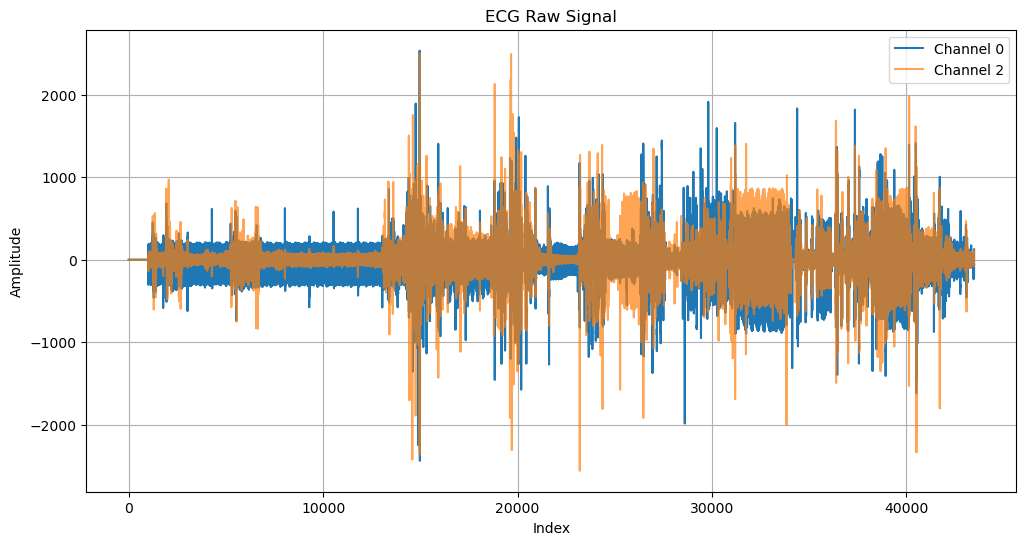

In [3]:
import sqlite3
# Attempt to inspect the uploaded file to understand its structure (binary or text-based)
file_path = './solmi/John Silver_SHC_U8A_20240905_131522.rpd'

# Read the first few bytes of the file to identify its format
with open(file_path, 'rb') as file:
    file_header = file.read(256)  # Read the first 256 bytes for analysis

file_header

# Connect to the SQLite database
db_path = './solmi/John Silver_SHC_U8A_20240905_131522.rpd'
connection = sqlite3.connect(db_path)

# Fetch table names from the database
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Close the connection for now
connection.close()

# Display the tables
tables

# Reconnect to the SQLite database
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Fetch the first few rows from the 'ecg_raw' table to inspect its structure
cursor.execute("PRAGMA table_info(ecg_raw);")  # Get column information
ecg_raw_columns = cursor.fetchall()

cursor.execute("SELECT * FROM ecg_raw LIMIT 10;")  # Fetch first 10 rows of data
ecg_raw_sample = cursor.fetchall()

# Close the connection
connection.close()

(ecg_raw_columns, ecg_raw_sample)


import pandas as pd
import matplotlib.pyplot as plt

# Reconnect to the SQLite database to extract the full 'ecg_raw' table
connection = sqlite3.connect(db_path)
query = "SELECT * FROM ecg_raw;"
ecg_raw_data = pd.read_sql_query(query, connection)
connection.close()

# Display the first few rows of the data
ecg_raw_data.head()

# Plot the data to visualize the ECG signals
plt.figure(figsize=(12, 6))
plt.plot(ecg_raw_data['ecg_index'], ecg_raw_data['ecg_ch0'], label='Channel 0')
plt.plot(ecg_raw_data['ecg_index'], ecg_raw_data['ecg_ch2'], label='Channel 2', alpha=0.7)
plt.title('ECG Raw Signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



make the segment from qtdb

In [43]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import os
import pickle

def prepare_segments(QTpath='data/qt-database-1.0.0/', output_dir='data/original_segments/'):
    # Desired sampling frequency
    newFs = 360

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Preprocessing signals
    namesPath = glob.glob(QTpath + "/*.dat")

    for i in namesPath:
        # Reading signals
        aux = i.split('.dat')
        register_name = aux[0].split('/')[-1]
        signal, fields = wfdb.rdsamp(aux[0])
        qu = len(signal)

        # Reading annotations
        ann = wfdb.rdann(aux[0], 'pu1')
        anntype = ann.symbol
        annSamples = ann.sample

        # Obtaining P wave start positions
        Anntype = np.array(anntype)
        idx = Anntype == 'p'
        Pidx = annSamples[idx]
        idxS = Anntype == '('
        Sidx = annSamples[idxS]
        idxR = Anntype == 'N'
        Ridx = annSamples[idxR]

        ind = np.zeros(len(Pidx))

        for j in range(len(Pidx)):
            arr = np.where(Pidx[j] > Sidx)
            arr = arr[0]
            ind[j] = arr[-1]

        ind = ind.astype(np.int64)
        Pstart = Sidx[ind]

        # Shift 40ms before P wave start
        Pstart = Pstart - int(0.04 * fields['fs'])

        # Extract first channel
        auxSig = signal[0:qu, 0]

        # Beats separation and removing outliers
        beats = list()
        for k in range(len(Pstart) - 1):
            remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k + 1])
            if np.sum(remove) < 2:
                beats.append(auxSig[Pstart[k]:Pstart[k + 1]])

        # Process each beat and save separately
        for idx, beat in enumerate(beats):
            # Padding data to avoid edge effects caused by resample
            L = math.ceil(len(beat) * newFs / fields['fs'])
            normBeat = list(reversed(beat)) + list(beat) + list(reversed(beat))

            # Resample beat by beat and truncate to desired length
            res = resample_poly(normBeat, newFs, fields['fs'])
            res = res[L - 1:2 * L - 1]

            # Save each segment with the signal name and index
            filename = f"{register_name}_segment_{idx}.pkl"
            with open(os.path.join(output_dir, filename), 'wb') as output_file:
                pickle.dump(res, output_file)

        print(f"Processed and saved segments for signal {register_name}")

# Run the function
prepare_segments(QTpath='data/qt-database-1.0.0/', output_dir='data/original_segments/')


Processed and saved segments for signal sel821
Processed and saved segments for signal sel34
Processed and saved segments for signal sel306
Processed and saved segments for signal sel308
Processed and saved segments for signal sele0106
Processed and saved segments for signal sel102
Processed and saved segments for signal sel233
Processed and saved segments for signal sel103
Processed and saved segments for signal sel52
Processed and saved segments for signal sel16483
Processed and saved segments for signal sel17152
Processed and saved segments for signal sele0136
Processed and saved segments for signal sel123
Processed and saved segments for signal sele0104
Processed and saved segments for signal sel840
Processed and saved segments for signal sele0405
Processed and saved segments for signal sel873
Processed and saved segments for signal sel808
Processed and saved segments for signal sel50
Processed and saved segments for signal sel14046
Processed and saved segments for signal sel41
Pro

In [ ]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

def Data_Preparation(samples):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    sn_train = []
    sn_test = []
    noise_indices_train = []
    noise_indices_test = []    
    
    skip_beats = 0
    # samples = 512
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb_keys)} signals to process.")
# b_np.shape는 (512,)로, 패딩을 포함한 전체 샘플 크기가 512임을 알 수 있습니다.
    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue
# 이 평균값을 b_sq의 각 값에서 빼는 과정은 신호의 중앙화 작업입니다. 즉, 신호의 값들이 배열의 양 끝 값의 평균을 기준으로 대칭적으로 배치되도록 변환됩니다.
# 이 계산을 통해 신호의 첫 값과 마지막 값에 대한 편향을 제거하고, 신호를 중앙으로 이동시키는 효과가 있습니다.
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            if signal_name in test_set:
                beats_test.append(b_np)
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    # size=len(beats_train): beats_train의 길이만큼 난수를 생성합니다. 즉, beats_train에 있는 심박 데이터의 개수와 동일한 수의 난수를 생성합니다.
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # Adding noise to train
    # https://chatgpt.com/g/g-cKXjWStaE-python/c/66e1471b-57b4-8006-b921-233e7803fcab
    for beat_idx, beat in enumerate(beats_train):
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

                
    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    # Saving the random array so we can use it on the amplitude segmentation tables
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
    
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0
    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test


In [4]:
# import os
# import numpy as np
# from scipy.fft import fft
# import glob
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle


# def make_fourier(inputs, n, fs):
#     T = n / fs
#     k = np.arange(n)
#     freq = k / T
#     freq = freq[range(int(n / 2))]

#     signal_list = []
#     for i in range(inputs.shape[0]):
#         y = inputs[i, :]
#         Y = fft(y) / n  # FFT and normalization
#         Y = np.abs(Y[range(int(n / 2))])
#         Y_full = np.hstack([Y, Y])  # Duplicate to match 512 samples in time-domain
#         signal_list.append(Y_full)

#     return np.asarray(signal_list)


# def Data_Preparation_with_Fourier(samples, fs=360):
#     print('Getting the Data ready ...')
    
#     # Create directories for saving segments if they don't exist
#     os.makedirs('data/noisy_segments/train', exist_ok=True)
#     os.makedirs('data/noisy_segments/test', exist_ok=True)

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load QT Database
#     with open('data/QTDatabase.pkl', 'rb') as input:
#         qtdb = pickle.load(input)

#     print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     #####################################
#     # Data split
#     #####################################
#     test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
#                 'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
#                 'sel14046', 'sel15814']

#     beats_train = []
#     beats_test = []
#     fourier_train_x = []
#     fourier_test_x = []
#     fourier_train_y = []
#     fourier_test_y = []
#     valid_train_indices = []  # To keep track of valid indices in training data
#     valid_test_indices = []   # To keep track of valid indices in test data
#     noise_indices_train = []
#     noise_indices_test = []
#     sn_train = []
#     sn_test = []
#     skip_beats = 0
#     qtdb_keys = list(qtdb.keys())

#     print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")

#     for i in range(len(qtdb_keys)):
#         signal_name = qtdb_keys[i]

#         for b in qtdb[signal_name]:
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier transform of the clean beat
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

#             # Determine if the beat belongs to the test or train set
#             if signal_name in test_set:
#                 beats_test.append(b_np)
#                 fourier_test_y.append(fourier_transformed_y[0])
#                 valid_test_indices.append(len(beats_test) - 1)
#             else:
#                 beats_train.append(b_np)
#                 fourier_train_y.append(fourier_transformed_y[0])
#                 valid_train_indices.append(len(beats_train) - 1)

#         print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     noise_index = 0

# # Adding noise to training data and saving each noisy segment
#     for beat_idx, beat in enumerate(beats_train):
#         # signal_name = qtdb_keys[beat_idx % len(qtdb_keys)]  # Each signal gets processed by its key
#         if (beat_idx // 10) % 2 == 0:
#             selected_channel = beat_idx % 2
#         else:
#             selected_channel = (beat_idx + 1) % 2
#         # print(beat_idx)
#         noise_combination_idx = (beat_idx % 7) + 1
#         noise = combined_noise[selected_channel][:, noise_combination_idx]
#         noise_segment = noise[noise_index:noise_index + samples]
#         beat_max_value = np.max(beat) - np.min(beat)
#         noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#         Ase = noise_max_value / beat_max_value
#         alpha = rnd_train[beat_idx] / Ase
#         signal_noise = beat + alpha * noise_segment
#         sn_train.append(signal_noise)

#         # Debug: Print each save action for clarity
#         print(f"noise idx: {noise_combination_idx}, segment idx: {beat_idx}")

#         # Save the noisy segment with signal name, noise index, and beat index in the filename
#         with open(f'data/noisy_segments/train/noise_{noise_combination_idx}_segment_{beat_idx}.pkl', 'wb') as segment_file:
#             pickle.dump(signal_noise, segment_file)

#         fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#         fourier_train_x.append(fourier_transformed_x[0])
#         noise_indices_train.append(noise_combination_idx)

#         noise_index += samples
#         if noise_index > (len(noise) - samples):
#             noise_index = 0

#     # Adding noise to test data and saving each noisy segment
#     noise_index = 0
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test.npy', rnd_test)

#     for beat_idx, beat in enumerate(beats_test):
#         # signal_name = qtdb_keys[valid_test_indices[beat_idx] % len(qtdb_keys)]  # Each signal gets processed by its key
#         if (beat_idx // 10) % 2 == 0:
#             selected_channel = beat_idx % 2
#         else:
#             selected_channel = (beat_idx + 1) % 2
#         # print(beat_idx)
#         noise_combination_idx = (beat_idx % 7) + 1
#         noise = combined_noise[selected_channel][:, noise_combination_idx]
#         noise_segment = noise[noise_index:noise_index + samples]
#         beat_max_value = np.max(beat) - np.min(beat)
#         noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#         Ase = noise_max_value / beat_max_value
#         alpha = rnd_test[beat_idx] / Ase
#         signal_noise = beat + alpha * noise_segment
#         sn_test.append(signal_noise)

#         # Debug: Print each save action for clarity
#         print(f"noise idx: {noise_combination_idx}, segment idx: {beat_idx}")

#         # Save the noisy segment with signal name, noise index, and beat index in the filename
#         with open(f'data/noisy_segments/test/noise_{noise_combination_idx}_segment_{beat_idx}.pkl', 'wb') as segment_file:
#             pickle.dump(signal_noise, segment_file)

#         fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#         fourier_test_x.append(fourier_transformed_x[0])
#         noise_indices_test.append(noise_combination_idx)

#         noise_index += samples
#         if noise_index > (len(noise) - samples):
#             noise_index = 0

#     # Prepare final dataset arrays
#     X_train = np.array(sn_train)[valid_train_indices]
#     X_test = np.array(sn_test)[valid_test_indices]
#     y_train = np.array(beats_train)[valid_train_indices]
#     y_test = np.array(beats_test)[valid_test_indices]
#     F_train_x = np.array(fourier_train_x)[valid_train_indices]
#     F_test_x = np.array(fourier_test_x)[valid_test_indices]
#     F_train_y = np.array(fourier_train_y)[valid_train_indices]
#     F_test_y = np.array(fourier_test_y)[valid_test_indices]

#     # Reshape data to match time-domain shape
#     X_train = np.expand_dims(X_train, axis=2)
#     y_train = np.expand_dims(y_train, axis=2)
#     X_test = np.expand_dims(X_test, axis=2)
#     y_test = np.expand_dims(y_test, axis=2)
#     F_train_x = np.expand_dims(F_train_x, axis=2)
#     F_train_y = np.expand_dims(F_train_y, axis=2)
#     F_test_x = np.expand_dims(F_test_x, axis=2)
#     F_test_y = np.expand_dims(F_test_y, axis=2)

#     Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
#     print('Dataset ready to use.')

#     return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test


In [9]:
import numpy as np
from scipy.fft import fft
import glob
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle


def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    
    Parameters:
    inputs: 입력 신호 (원본 신호, 2D 배열 - (배치 크기, 샘플 수))
    n: FFT 샘플 수
    fs: 샘플링 주파수 (예: 360 Hz)
    
    Returns:
    주파수 도메인에서 얻은 신호 (FFT), time-domain과 동일한 크기
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        # Magnitude 값을 두 배로 늘려 time-domain과 동일한 shape으로 맞춤 (512)
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier(samples, fs=360):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    # 노이즈 인덱스 저장 리스트
    noise_indices_train = []
    noise_indices_test = []
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")

    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue

            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            if signal_name in test_set:
                beats_test.append(b_np)
                fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # To ensure equal selection of channels
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
        
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = (beat_idx % 7) + 1  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0


    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    # Fourier 정보도 포함된 주파수 도메인 데이터셋 생성
    F_train_x = np.array(fourier_train_x)[valid_train_indices]
    F_test_x = np.array(fourier_test_x)[valid_test_indices]
    F_train_y = np.array(fourier_train_y)[valid_train_indices]
    F_test_y = np.array(fourier_test_y)[valid_test_indices]

    # Shape을 time-domain과 동일하게 확장
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]
    
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test


In [10]:
# Unpack the dataset
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

In [5]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = [  'DRNN',
                        'FCN-DAE',
                        'Vanilla L',
                        'Vanilla NL',
                        'Multibranch LANL',
                        'Multibranch LANLD','Transformer_DAE','Transformer_COMBDAE','Transformer_COMBDAE_updated']



In [6]:
#============================================================
#
#  Deep Learning BLW Filtering
#  Metrics
#
#  author: Francisco Perdigon Romero
#  email: fperdigon88@gmail.com
#  github id: fperdigon
#
#===========================================================

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')



In [7]:
with open('1030/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1030/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Vanilla L
with open('1030/test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_Vanilla_L = pickle.load(input)
# Load Results Exp Vanilla NL
with open('1030/test_results_' + dl_experiments[3] + '.pkl', 'rb') as input:
    test_Vanilla_NL = pickle.load(input)
# Load Results Multibranch LANL
with open('1030/test_results_' + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Multibranch_LANL = pickle.load(input)
# Load Results Multibranch LANLD
with open('1030/test_results_' + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Multibranch_LANLD = pickle.load(input)
# Load Results Transformer_DAE
with open('1206/test_results_' + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('1206/test_results_' + dl_experiments[7] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
        
with open('1104/test_results_' + dl_experiments[8] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE_updated = pickle.load(input)
    
# Load Result FIR Filter
with open('1005/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1005/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)

SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)
# Vanilla L
[X_test, y_test, y_pred] = test_Vanilla_L
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_1 = SNR(y_test, y_pred)
# Vanilla_NL
[X_test, y_test, y_pred] = test_Vanilla_NL
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_2 = SNR(y_test, y_pred)
# Multibranch_LANL
[X_test, y_test, y_pred] = test_Multibranch_LANL
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_3 = SNR(y_test, y_pred)
# Multibranch_LANLD
[X_test, y_test, y_pred] = test_Multibranch_LANLD
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_4 = SNR(y_test, y_pred)
# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_5 = SSD(y_test, y_pred)
MAD_values_DL_exp_5 = MAD(y_test, y_pred)
PRD_values_DL_exp_5 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_5 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_5 = SNR(y_test, y_pred)
# Transformer_FDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_6 = SSD(y_test, y_pred)
MAD_values_DL_exp_6 = MAD(y_test, y_pred)
PRD_values_DL_exp_6 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_6 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_6 = SNR(y_test, y_pred)
# Transformer_FDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE_updated
SSD_values_DL_exp_7 = SSD(y_test, y_pred)
MAD_values_DL_exp_7 = MAD(y_test, y_pred)
PRD_values_DL_exp_7 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_7 = COS_SIM(y_test, y_pred)

SNR_values_DL_exp_7 = SNR(y_test, y_pred)
# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)

SNR_values_FIR = SNR(y_test, y_filter)
# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)

SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4,
            SSD_values_DL_exp_5,
            SSD_values_DL_exp_6,
            SSD_values_DL_exp_7]
MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4,
        MAD_values_DL_exp_5,
        MAD_values_DL_exp_6,
        MAD_values_DL_exp_7
        ]
PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4,
        PRD_values_DL_exp_5,
        PRD_values_DL_exp_6,
        PRD_values_DL_exp_7
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4,
            COS_SIM_values_DL_exp_5,
            COS_SIM_values_DL_exp_6,
            COS_SIM_values_DL_exp_7
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4,
        SNR_values_DL_exp_5,
        SNR_values_DL_exp_6,
        SNR_values_DL_exp_7]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


FileNotFoundError: [Errno 2] No such file or directory: '1206/test_results_Transformer_DAE.pkl'

In [14]:
np.array(test_DRNN).shape
# # np.array(test_Transformer_COMBDAE_FreTS).shape

(3, 13316, 512, 1)

In [59]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    """ 디렉토리가 존재하지 않으면 생성 """
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_hboxplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)  # 가로로 누운 boxplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_violinplots(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.violinplot(data=pd_df, palette="Set3", bw=.2, cut=1, linewidth=1, orient="h")  # 가로로 누운 violinplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_barplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.barplot(data=pd_df, orient="h")  # 가로로 누운 barplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


def generate_boxplot(np_data, description, ylabel, log, save_dir, filename, set_x_axis_size=None):
    # Process the results and store in Pandas DataFrame
    ensure_directory(save_dir)  # 디렉토리 생성
    col = description
    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set(style="whitegrid")
    ax = sns.boxplot(data=pd_df, orient="h")  # 가로로 누운 boxplot

    if log:
        ax.set_xscale("log")

    if set_x_axis_size is not None:
        ax.set_xlim(set_x_axis_size)

    ax.set(xlabel='Models/Methods', ylabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    # Save plot to file
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")


# 저장 경로 설정
save_directory = 'plots'

# 파일 이름 설정
filename_ssd_hbox = 'ssd_hboxplot.png'
filename_ssd_violin = 'ssd_violinplot.png'
filename_ssd_bar = 'ssd_barplot.png'
filename_ssd_box = 'ssd_boxplot.png'

filename_mad_hbox = 'mad_hboxplot.png'
filename_mad_violin = 'mad_violinplot.png'
filename_mad_bar = 'mad_barplot.png'
filename_mad_box = 'mad_boxplot.png'

filename_prd_hbox = 'prd_hboxplot.png'
filename_prd_violin = 'prd_violinplot.png'
filename_prd_bar = 'prd_barplot.png'
filename_prd_box = 'prd_boxplot.png'

filename_cos_hbox = 'cos_hboxplot.png'
filename_cos_violin = 'cos_violinplot.png'
filename_cos_bar = 'cos_barplot.png'
filename_cos_box = 'cos_boxplot.png'

# SSD 그래프들 생성
print("Generating SSD plots...")
generate_hboxplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_hbox, set_x_axis_size=(0, 100.1))
generate_violinplots(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_violin, set_x_axis_size=(0, 100.1))
generate_barplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_bar, set_x_axis_size=(0, 100.1))
generate_boxplot(SSD_all, Exp_names, 'SSD (au)', log=False, save_dir=save_directory, filename=filename_ssd_box, set_x_axis_size=(0, 100.1))

# MAD 그래프들 생성
print("Generating MAD plots...")
generate_hboxplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_hbox, set_x_axis_size=(0, 3.01))
generate_violinplots(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_violin, set_x_axis_size=(0, 3.01))
generate_barplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_bar, set_x_axis_size=(0, 3.01))
generate_boxplot(MAD_all, Exp_names, 'MAD (au)', log=False, save_dir=save_directory, filename=filename_mad_box, set_x_axis_size=(0, 3.01))

# PRD 그래프들 생성
print("Generating PRD plots...")
generate_hboxplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_hbox, set_x_axis_size=(0, 150.1))
generate_violinplots(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_violin, set_x_axis_size=(0, 150.1))
generate_barplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_bar, set_x_axis_size=(0, 150.1))
generate_boxplot(PRD_all, Exp_names, 'PRD (au)', log=False, save_dir=save_directory, filename=filename_prd_box, set_x_axis_size=(0, 150.1))

# Cosine Similarity 그래프들 생성
print("Generating Cosine Similarity plots...")
generate_hboxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_hbox, set_x_axis_size=(0, 1))
generate_violinplots(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_violin, set_x_axis_size=(0, 1))
generate_barplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_bar, set_x_axis_size=(0, 1))
generate_boxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, save_dir=save_directory, filename=filename_cos_box, set_x_axis_size=(0, 1))


Generating SSD plots...
Saved: plots/ssd_hboxplot.png
Saved: plots/ssd_violinplot.png
Saved: plots/ssd_barplot.png
Saved: plots/ssd_boxplot.png
Generating MAD plots...
Saved: plots/mad_hboxplot.png
Saved: plots/mad_violinplot.png
Saved: plots/mad_barplot.png
Saved: plots/mad_boxplot.png
Generating PRD plots...
Saved: plots/prd_hboxplot.png
Saved: plots/prd_violinplot.png
Saved: plots/prd_barplot.png
Saved: plots/prd_boxplot.png
Generating Cosine Similarity plots...
Saved: plots/cos_hboxplot.png
Saved: plots/cos_violinplot.png
Saved: plots/cos_barplot.png
Saved: plots/cos_boxplot.png


In [16]:
rnd_test = np.load('rnd_test.npy')
# print(rnd_test.shape)
# 13316,
# rnd_test = np.concatenate([rnd_test, rnd_test])
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # real number of segmentations is len(segmentations) - 1
SSD_seg_all = []
MAD_seg_all = []
PRD_seg_all = []
COS_SIM_seg_all = []
SNR_seg_all = []

for idx_exp in range(len(Exp_names)):
    SSD_seg = [[] for _ in range(len(segm) - 1)]
    MAD_seg = [[] for _ in range(len(segm) - 1)]
    PRD_seg = [[] for _ in range(len(segm) - 1)]
    COS_SIM_seg = [[] for _ in range(len(segm) - 1)]
    SNR_seg = [[] for _ in range(len(segm) - 1)]
    for idx_seg in range(len(segm) - 1):
        for idx in range(len(rnd_test)):
            if segm[idx_seg] < rnd_test[idx] < segm[idx_seg + 1]:
                # SSD
                SSD_seg[idx_seg].append(SSD_all[idx_exp][idx])
                # MAD
                MAD_seg[idx_seg].append(MAD_all[idx_exp][idx])
                # PRD
                PRD_seg[idx_seg].append(PRD_all[idx_exp][idx])
                # COS_SIM
                COS_SIM_seg[idx_seg].append(CORR_all[idx_exp][idx])
                # SNR
                SNR_seg[idx_seg].append(SNR_all[idx_exp][idx])
    # 마지막 구간 처리
    SSD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            SSD_seg[-1].append(SSD_all[idx_exp][idx])
    SSD_seg_all.append(SSD_seg)
    # MAD
    MAD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            MAD_seg[-1].append(MAD_all[idx_exp][idx])
    MAD_seg_all.append(MAD_seg)
    # PRD
    PRD_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            PRD_seg[-1].append(PRD_all[idx_exp][idx])
    PRD_seg_all.append(PRD_seg)
    # COS SIM
    COS_SIM_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            COS_SIM_seg[-1].append(CORR_all[idx_exp][idx])
    COS_SIM_seg_all.append(COS_SIM_seg)
    # SNR
    SNR_seg[-1] = []
    for idx in range(len(rnd_test)):
        if rnd_test[idx] > segm[-2]:
            SNR_seg[-1].append(SNR_all[idx_exp][idx])
    SNR_seg_all.append(SNR_seg)
    
# Printing Tables
seg_table_column_name = []
for idx_seg in range(len(segm) - 1):
    column_name = str(segm[idx_seg]) + ' < noise < ' + str(segm[idx_seg + 1])
    seg_table_column_name.append(column_name)
# SSD Table
SSD_seg_all = np.array(SSD_seg_all)
SSD_seg_all = np.swapaxes(SSD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the SSD metric')
generate_table(seg_table_column_name, SSD_seg_all, Exp_names)
# MAD Table
MAD_seg_all = np.array(MAD_seg_all)
MAD_seg_all = np.swapaxes(MAD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the MAD metric')
generate_table(seg_table_column_name, MAD_seg_all, Exp_names)
# PRD Table
PRD_seg_all = np.array(PRD_seg_all)
PRD_seg_all = np.swapaxes(PRD_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the PRD metric')
generate_table(seg_table_column_name, PRD_seg_all, Exp_names)
# COS SIM Table
COS_SIM_seg_all = np.array(COS_SIM_seg_all)
COS_SIM_seg_all = np.swapaxes(COS_SIM_seg_all, 0, 1)
print('\n')
print('Printing Table for different noise values on the COS SIM metric')
generate_table(seg_table_column_name, COS_SIM_seg_all, Exp_names)
# SNR Table
SNR_seg_all = np.array(SNR_seg_all)
SNR_seg_all = np.swapaxes(SNR_seg_all, 0, 1)

print('\n')
print('Printing Table for different noise values on the SNR metric')
generate_table(seg_table_column_name, SNR_seg_all, Exp_names)
# print(SNR_seg_all)
# 저장 경로 설정

/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.




Printing Table for different noise values on the SSD metric


+-----------------------------+-------------------+-------------------+-------------------+-------------------+
|         Method/Model        | 0.2 < noise < 0.6 | 0.6 < noise < 1.0 | 1.0 < noise < 1.5 | 1.5 < noise < 2.0 |
+-----------------------------+-------------------+-------------------+-------------------+-------------------+
|          FIR Filter         |  94.388 (155.914) |  93.554 (160.048) |  94.349 (157.897) |  98.520 (162.307) |
|          IIR Filter         |  87.882 (141.816) |  86.813 (145.591) |  85.808 (138.160) |  90.612 (146.779) |
|             DRNN            |   5.349 (7.388)   |   6.342 (8.758)   |   7.569 (9.903)   |  10.505 (13.027)  |
|           FCN-DAE           |   5.789 (8.359)   |   7.226 (9.183)   |   9.822 (14.310)  |  13.766 (19.490)  |
|          Vanilla L          |  10.700 (11.840)  |  14.628 (13.987)  |  23.012 (21.106)  |  36.859 (36.047)  |
|          Vanilla NL         |   7.171 

/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


+-----------------------------+-------------------+-------------------+-------------------+-------------------+
|         Method/Model        | 0.2 < noise < 0.6 | 0.6 < noise < 1.0 | 1.0 < noise < 1.5 | 1.5 < noise < 2.0 |
+-----------------------------+-------------------+-------------------+-------------------+-------------------+
|          FIR Filter         |   0.575 (0.238)   |   0.573 (0.234)   |   0.575 (0.234)   |   0.572 (0.235)   |
|          IIR Filter         |   0.586 (0.241)   |   0.585 (0.237)   |   0.588 (0.236)   |   0.585 (0.236)   |
|             DRNN            |   0.897 (0.086)   |   0.874 (0.107)   |   0.848 (0.134)   |   0.798 (0.187)   |
|           FCN-DAE           |   0.886 (0.106)   |   0.846 (0.147)   |   0.798 (0.188)   |   0.735 (0.229)   |
|          Vanilla L          |   0.740 (0.135)   |   0.657 (0.132)   |   0.555 (0.148)   |   0.470 (0.157)   |
|          Vanilla NL         |   0.877 (0.089)   |   0.810 (0.130)   |   0.733 (0.170)   |   0.650 (0.2

/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## sample 로 잘라서 해보기

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def visualize_signals(qtdb_path='data/QTDatabase.pkl', 
                      combined_noise_path='data/CombinedNoise.pkl',
                      transformer_combdae_path='1030/test_results_Transformer_COMBDAE.pkl',
                      output_dir='visualizations'):
    
    # 데이터 로드
    with open(qtdb_path, 'rb') as f:
        qtdb = pickle.load(f)
    
    with open(combined_noise_path, 'rb') as f:
        combined_noise = pickle.load(f)
    
    with open(transformer_combdae_path, 'rb') as f:
        filtered_data = pickle.load(f)
    
    X_test, y_test, y_pred = filtered_data

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 샘플링 주파수와 세그먼트 길이 설정
    fs = 360
    segment_length = 15 * fs

    for signal_name, beats in qtdb.items():
        # 전체 신호 생성 (15초)
        original_signal = np.concatenate(beats)[:segment_length]

        # 노이즈 추가
        rnd_scale = np.random.randint(low=20, high=200) / 100
        noise = combined_noise[0][:, 1]  # 첫 번째 채널, 두 번째 노이즈 조합 선택
        noise_segment = noise[:segment_length]
        
        beat_max_value = np.max(original_signal) - np.min(original_signal)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value
        alpha = rnd_scale / Ase
        noisy_signal = original_signal + alpha * noise_segment

        # noisy_signal을 X_test와 같은 길이(512)로 자르기
        noisy_signal = noisy_signal[:512]
        
        # 필터링된 신호 찾기 (가장 유사한 신호 선택)
        noisy_signal_reshaped = noisy_signal.reshape(1, -1, 1)
        diff = np.sum((X_test - noisy_signal_reshaped)**2, axis=(1, 2))
        closest_idx = np.argmin(diff)
        filtered_signal = y_pred[closest_idx].flatten()

        # 시간 축 생성
        time = np.arange(segment_length) / fs

        # Figure 1: 원본 신호와 노이즈가 추가된 신호
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.plot(time, original_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(2, 1, 2)
        plt.plot(time[:512], noisy_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Noisy Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/{signal_name}_original_vs_noisy.png', dpi=300)
        plt.close()

        # Figure 2: 원본 신호와 필터링된 신호
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.plot(time[:512], original_signal[:512], linewidth=0.5)
        plt.title(f'{signal_name} - Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(2, 1, 2)
        plt.plot(time[:512], filtered_signal, linewidth=0.5)
        plt.title(f'{signal_name} - Filtered Signal (Transformer_COMBDAE)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/{signal_name}_original_vs_filtered.png', dpi=300)
        plt.close()

        print(f"Visualized signals for {signal_name}")

# 시각화 실행
visualize_signals()

Visualized signals for sele0122
Visualized signals for sele0107
Visualized signals for sel16272
Visualized signals for sele0604
Visualized signals for sel104
Visualized signals for sel232
Visualized signals for sel16539
Visualized signals for sel33
Visualized signals for sele0606
Visualized signals for sel32
Visualized signals for sel871
Visualized signals for sel39
Visualized signals for sele0110
Visualized signals for sele0126
Visualized signals for sel302
Visualized signals for sele0129
Visualized signals for sel14172
Visualized signals for sele0114
Visualized signals for sel883
Visualized signals for sel48
Visualized signals for sele0104
Visualized signals for sele0509
Visualized signals for sele0603
Visualized signals for sel38
Visualized signals for sel230
Visualized signals for sel14157
Visualized signals for sel16773
Visualized signals for sel114
Visualized signals for sel233
Visualized signals for sel52
Visualized signals for sel35
Visualized signals for sele0136
Visualized si

sel16786_noise_6_segment_103.pkl
sel16786_noise_6_segment_208.pkl
sel16786_noise_6_segment_313.pkl
sel16786_noise_6_segment_418.pkl
sel16786_noise_6_segment_523.pkl
sel16786_noise_6_segment_628.pkl
sel16786_noise_6_segment_733.pkl
sel16786_noise_6_segment_838.pkl
sel16786_noise_6_segment_943.pkl
sel16786_noise_6_segment_1048.pkl
sel16786_noise_6_segment_1153.pkl
sel16786_noise_6_segment_1258.pkl
sel16786_noise_6_segment_1363.pkl
sel16786_noise_6_segment_1468.pkl
sel16786_noise_6_segment_1573.pkl
sel16786_noise_6_segment_1678.pkl
sel16786_noise_6_segment_1783.pkl
sel16786_noise_6_segment_1888.pkl
sel16786_noise_6_segment_1993.pkl
sel16786_noise_6_segment_2098.pkl
sel16786_noise_6_segment_2203.pkl
sel16786_noise_6_segment_2308.pkl
sel16786_noise_6_segment_2413.pkl
sel16786_noise_6_segment_2518.pkl
sel16786_noise_6_segment_2623.pkl
sel16786_noise_6_segment_2728.pkl
sel16786_noise_6_segment_2833.pkl
sel16786_noise_6_segment_2938.pkl
sel16786_noise_6_segment_3043.pkl
sel16786_noise_6_segmen

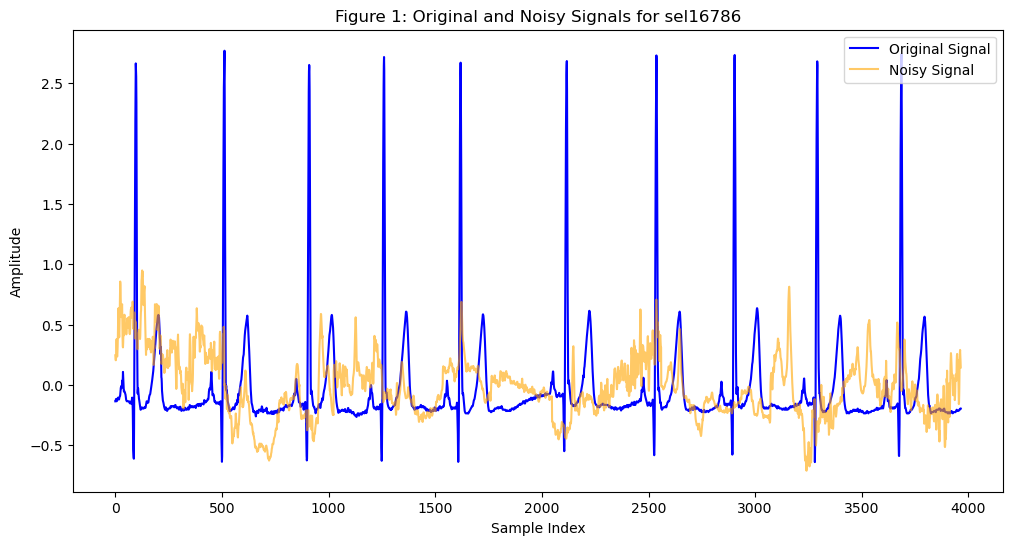

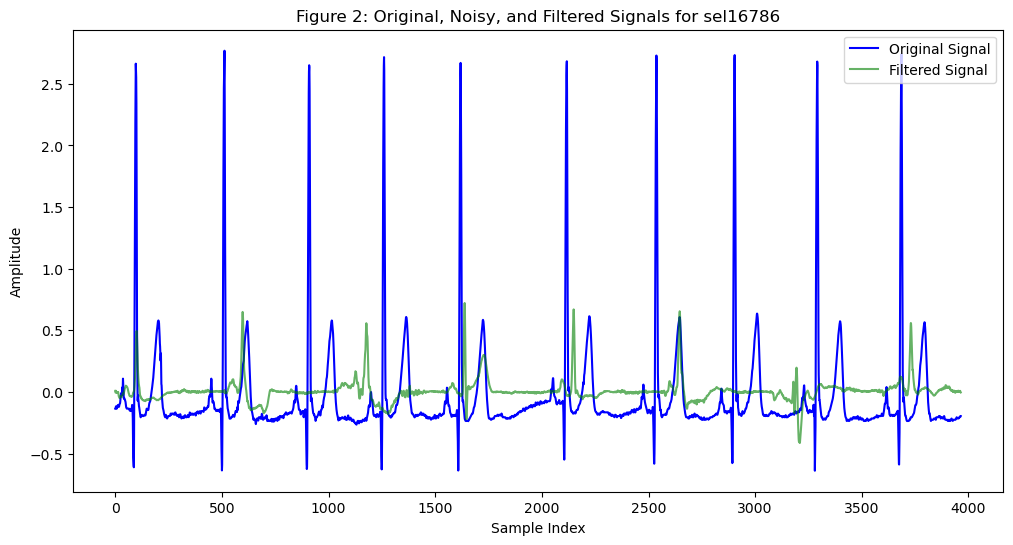

In [110]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the Transformer_COMBDAE filtered results
with open('1030/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    test_results_combdae = pickle.load(input)

# Define a function to load all noisy segments for a given signal name from a directory
def load_noisy_segments(signal_name, segment_dir='data/noisy_segments/test'):
    noisy_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            noisy_segment = pickle.load(segment_file)
            print(filename)
            noisy_segments.append(noisy_segment)
    return noisy_segments

# Define a function to load all original segments for a given signal name from a directory
def load_original_segments(signal_name, segment_dir='data/original_segments'):
    original_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            # print(filename)
            original_segment = pickle.load(segment_file)
            original_segments.append(original_segment)
    return original_segments

# Load the noisy and original segments
signal_name = 'sel16786'
original_segments = load_original_segments(signal_name, 'data/original_segments')
noisy_segments = load_noisy_segments(signal_name, 'data/noisy_segments/test')
_, _, filtered_segments = test_results_combdae  # Assuming this is the format [X_test, y_test, y_pred]

# Ensure the number of segments match between original, noisy, and filtered data
min_segments = min(len(original_segments), len(noisy_segments), len(filtered_segments))
original_segments = original_segments[:min_segments]
noisy_segments = noisy_segments[:min_segments]
filtered_segments = filtered_segments[:min_segments]

# Concatenate the first 5 segments into a continuous signal for each type
num_segments_to_display = 10
concatenated_original = np.concatenate(original_segments[:num_segments_to_display])
concatenated_noisy = np.concatenate(noisy_segments[:num_segments_to_display])
concatenated_filtered = np.concatenate(filtered_segments[:num_segments_to_display])

# Truncate all concatenated signals to the length of the shortest one
min_length = min(len(concatenated_original), len(concatenated_noisy), len(concatenated_filtered))
concatenated_original = concatenated_original[:min_length]
concatenated_noisy = concatenated_noisy[:min_length]
concatenated_filtered = concatenated_filtered[:min_length]

# Define the x-axis for plotting
x_axis = np.arange(min_length)

# Plot Figure 1: Original vs Noisy Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_noisy, label='Noisy Signal', color='orange', alpha=0.6)
plt.title(f'Figure 1: Original and Noisy Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot Figure 2: Original, Noisy, and Filtered Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_filtered, label='Filtered Signal', color='green', alpha=0.6)
plt.title(f'Figure 2: Original, Noisy, and Filtered Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


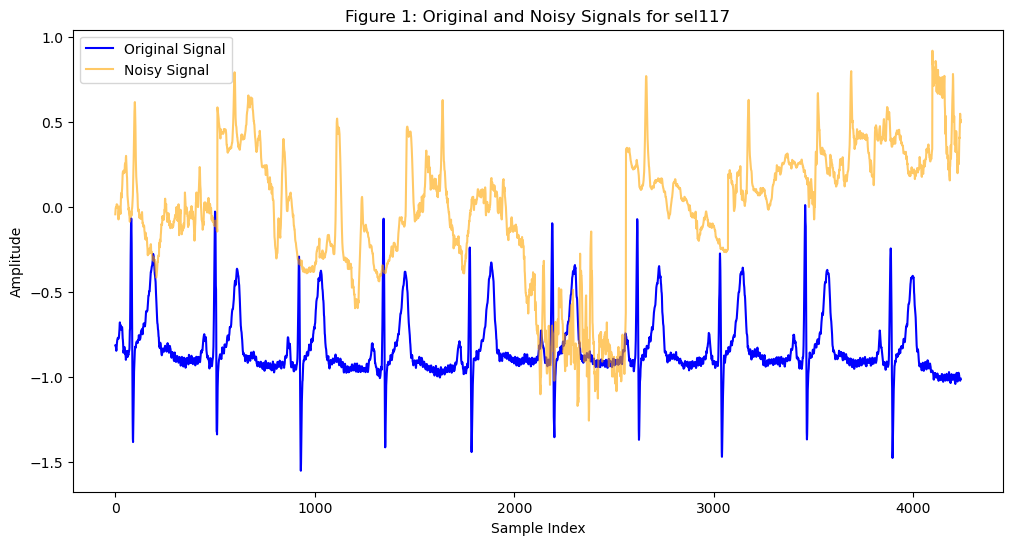

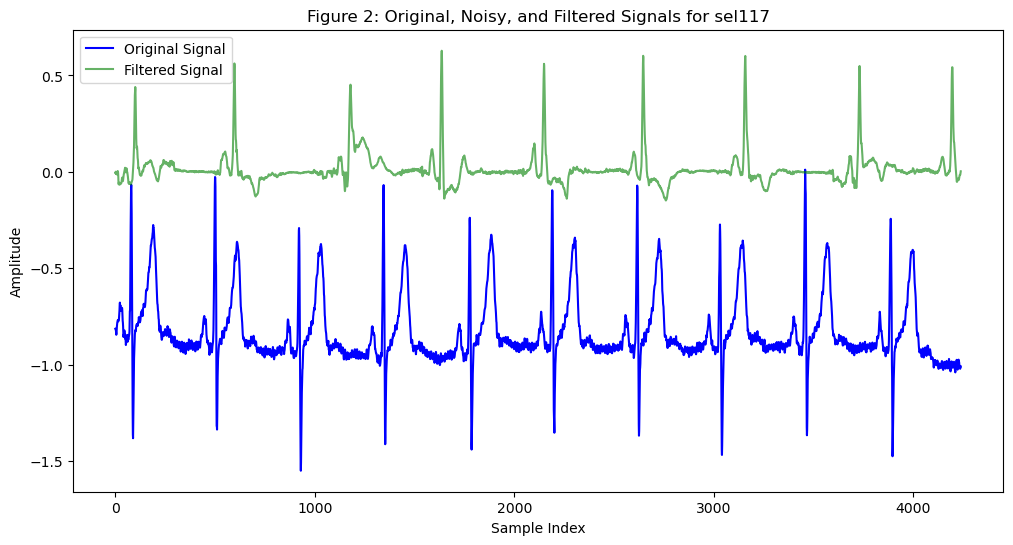

In [99]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the Transformer_COMBDAE filtered results
with open('1031_trainbwtestbw/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    test_results_combdae = pickle.load(input)

# Define a function to load all noisy segments for a given signal name from a directory
def load_noisy_segments(signal_name, segment_dir='data/noisy_segments/test'):
    noisy_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            noisy_segment = pickle.load(segment_file)
            noisy_segments.append(noisy_segment)
    return noisy_segments

# Define a function to load all original segments for a given signal name from a directory
def load_original_segments(signal_name, segment_dir='data/original_segments'):
    original_segments = []
    segment_files = sorted(
        [f for f in os.listdir(segment_dir) if f.startswith(signal_name)],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    for filename in segment_files:
        with open(os.path.join(segment_dir, filename), 'rb') as segment_file:
            original_segment = pickle.load(segment_file)
            original_segments.append(original_segment)
    return original_segments

# Load the noisy and original segments
signal_name = 'sel117'
original_segments = load_original_segments(signal_name, 'data/original_segments')
noisy_segments = load_noisy_segments(signal_name, 'data/noisy_segments/test')
_, _, filtered_segments = test_results_combdae  # Assuming this is the format [X_test, y_test, y_pred]

# Ensure the number of segments match between original, noisy, and filtered data
min_segments = min(len(original_segments), len(noisy_segments), len(filtered_segments))
original_segments = original_segments[:min_segments]
noisy_segments = noisy_segments[:min_segments]
filtered_segments = filtered_segments[:min_segments]

# Concatenate the first 5 segments into a continuous signal for each type
num_segments_to_display = 10
concatenated_original = np.concatenate(original_segments[:num_segments_to_display])
concatenated_noisy = np.concatenate(noisy_segments[:num_segments_to_display])
concatenated_filtered = np.concatenate(filtered_segments[:num_segments_to_display])

# Truncate all concatenated signals to the length of the shortest one
min_length = min(len(concatenated_original), len(concatenated_noisy), len(concatenated_filtered))
concatenated_original = concatenated_original[:min_length]
concatenated_noisy = concatenated_noisy[:min_length]
concatenated_filtered = concatenated_filtered[:min_length]

# Define the x-axis for plotting
x_axis = np.arange(min_length)

# Plot Figure 1: Original vs Noisy Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_noisy, label='Noisy Signal', color='orange', alpha=0.6)
plt.title(f'Figure 1: Original and Noisy Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot Figure 2: Original, Noisy, and Filtered Signals
plt.figure(figsize=(12, 6))
plt.plot(x_axis, concatenated_original, label='Original Signal', color='blue')
plt.plot(x_axis, concatenated_filtered, label='Filtered Signal', color='green', alpha=0.6)
plt.title(f'Figure 2: Original, Noisy, and Filtered Signals for {signal_name}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [117]:
import os
import glob

# Define paths
test_path = '/home/dhc99/ecg_denoise/data/noisy_segments/test'
train_path = '/home/dhc99/ecg_denoise/data/noisy_segments/train'

# Count pkl files in test directory
test_pkls = glob.glob(os.path.join(test_path, '*.pkl'))
test_count = len(test_pkls)

# Count pkl files in train directory
train_pkls = glob.glob(os.path.join(train_path, '*.pkl'))
train_count = len(train_pkls)

print(f"테스트 폴더의 pkl 파일 개수: {test_count}")
print(f"학습 폴더의 pkl 파일 개수: {train_count}")

테스트 폴더의 pkl 파일 개수: 13316
학습 폴더의 pkl 파일 개수: 72002


In [121]:
import os
import glob

# 경로 정의
test_path = '/home/dhc99/ecg_denoise/data/noisy_segments/test'
train_path = '/home/dhc99/ecg_denoise/data/noisy_segments/train'

# test 폴더에서 13316.pkl로 끝나는 파일 찾기
test_files = glob.glob(os.path.join(test_path, '*13315.pkl'))
print("\n테스트 폴더에서 찾은 파일들:")
for file in test_files:
    print(f"- {os.path.basename(file)}")

# train 폴더에서 13316.pkl로 끝나는 파일 찾기
train_files = glob.glob(os.path.join(train_path, '*13315.pkl'))
print("\n학습 폴더에서 찾은 파일들:")
for file in train_files:
    print(f"- {os.path.basename(file)}")

print(f"\n총 찾은 파일 개수: test={len(test_files)}, train={len(train_files)}")


테스트 폴더에서 찾은 파일들:
- sel41_noise_2_segment_13315.pkl

학습 폴더에서 찾은 파일들:
- sel41_noise_2_segment_13315.pkl

총 찾은 파일 개수: test=1, train=1


In [142]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise combination descriptions for labels
NOISE_COMBINATIONS = {
    1: "Baseline Wander (BW) only",
    2: "Electrode Motion (EM) only",
    3: "Muscle Artifact (MA) only",
    4: "BW + EM",
    5: "BW + MA",
    6: "EM + MA",
    7: "BW + EM + MA"
}

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information
def ecg_view_concatenated(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                          noise_indices=None, signal_name=None, save_dir='view', num_segments=5):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Select the specified number of segments to concatenate
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Label for noise combination
    noise_description = (
        f"Noise: {', '.join([str(NOISE_COMBINATIONS.get(idx, 'Unknown')) for idx in noise_indices[:num_segments]])}"
        if noise_indices else "Unknown Noise Combination"
    )
    
    # Plot concatenated signals
    fig, ax = plt.subplots(figsize=(16, 9))
    # plt.plot(ecg_blw_concat, 'k--', label=f'{noise_description}', alpha=0.7)
    # plt.plot(ecg_blw_concat, 'k--',  alpha=0.7)
    plt.plot(ecg_concat, 'g-', label='ECG Original', lw=2)
    # plt.plot(ecg_dl_concat, 'b-.', label=f'ECG {model_name} Filtered', lw=2.5)
    
    plt.grid(True)
    plt.ylabel('Amplitude (au)')
    plt.xlabel('Sample Index')
    plt.title('Ground Truth')
    leg = ax.legend()

    # Save the image
    filename = f"ECG_Concatenated_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath)
    plt.close(fig)  # Close figure to free memory
    print(f"Saved: {filepath}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1105/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 7
signals_index = [250,251,252,253,254,255,256]  # Indices of segments within the same signal to plot
noise_indices = [i for i in signals_index]  # Example noise indices

# Loop through each model and generate plots
for model_name, (X_test, y_test, y_pred) in model_results.items():
    # Prepare segments for the specific model
    ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
    ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
    dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

    # Plotting concatenated signals with noise information for the specific model
    ecg_view_concatenated(ecg_segments=ecg_signals2plot,
                          ecg_blw_segments=ecgbl_signals2plot,
                          ecg_dl_segments=dl_signals2plot,
                          model_name=model_name,
                          noise_indices=noise_indices,
                          signal_name=signal_name,
                          save_dir='view_comp',
                          num_segments=segments_to_plot)


Saved: view_comp/ECG_Concatenated_Example_Signal_DRNN_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_FCN-DAE_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Vanilla L_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Vanilla NL_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Multibranch LANL_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Multibranch LANLD_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Transformer_DAE_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Transformer_COMBDAE_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_Transformer_COMBDAE_updated_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_FIR_Filter_Segments_7.png
Saved: view_comp/ECG_Concatenated_Example_Signal_IIR_Filter_Segments_7.png


## 진짜 시각화


0.2 ~ 2.0 구간별로 하고싶었다.


In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def plot_concatenated_ecg_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
    """
    Generates a single plot of concatenated Original, Noisy, and Filtered ECG signals for a given noise range.
    """
    # Concatenate all segments
    ecg_concat_original = np.concatenate(ecg_original)
    ecg_concat_noisy = np.concatenate(ecg_noisy)
    ecg_concat_filtered = np.concatenate(ecg_filtered)

    # Create a figure
    plt.figure(figsize=(14, 6))

    # Plot Original, Noisy, and Filtered signals
    plt.plot(ecg_concat_original, label='Original', color='red', linewidth=1.5)
    plt.plot(ecg_concat_noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0, alpha=0.8)
    plt.plot(ecg_concat_filtered, label='Filtered', color='green', linewidth=1.2, alpha=0.85)

    # Add metrics as text
    metrics_text = (
        f"SSD: {np.mean(metrics['SSD']):.2f}, "
        f"MAD: {np.mean(metrics['MAD']):.3f}, "
        f"PRD: {np.mean(metrics['PRD']):.2f}, "
        f"Cosine Sim: {np.mean(metrics['COS_SIM']):.3f}"
    )
    plt.title(f"Noise Range: {noise_range}\nMetrics: {metrics_text}", fontsize=20, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Amplitude (a.u.)", fontsize=14)

    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)

    # Save the image
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

# Load Transformer_COMBDAE results
with open("1030/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, and Cosine Similarity metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD
    mad = np.mean(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}


# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0][:7]  # Limit to 7 segments

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    # Prepare metrics for this range
    metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": []}

    # Compute metrics for selected samples
    for idx in noise_indices:
        metrics = calculate_metrics(y_original=y_test[idx], y_filtered=y_pred[idx])
        for key, value in metrics.items():
            metrics_range[key].append(value)

    # Prepare data for plotting
    ecg_original = [y_test[idx].flatten() for idx in noise_indices]
    ecg_noisy = [X_test[idx].flatten() for idx in noise_indices]
    ecg_filtered = [y_pred[idx].flatten() for idx in noise_indices]

    # Save path for the plot
    save_dir = "view_comp_concat_plots"
    ensure_directory(save_dir)
    save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_concat_comparison.png")

    # Plot and save
    plot_concatenated_ecg_with_metrics(
        ecg_original, ecg_noisy, ecg_filtered, metrics_range,
        noise_range=f"{noise_start} < noise < {noise_end}",
        save_path=save_path
    )


Saved plot: view_comp_concat_plots/Noise_0.2_0.6_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_0.6_1.0_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_1.0_1.5_concat_comparison.png
Saved plot: view_comp_concat_plots/Noise_1.5_2.0_concat_comparison.png


밑에껀 샘플별 따로

In [4]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise combination descriptions for labels
NOISE_COMBINATIONS = {
    1: "Baseline Wander (BW) only",
    2: "Electrode Motion (EM) only",
    3: "Muscle Artifact (MA) only",
    4: "BW + EM",
    5: "BW + MA",
    6: "EM + MA",
    7: "BW + EM + MA"
}

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
    """
    Generates a side-by-side plot of Original, Noisy, and Filtered ECG signals for a given noise range.
    """
    plt.figure(figsize=(10, 12))  # Adjust figure size for better visibility

    # Plotting for each noise range
    for i, (original, noisy, filtered) in enumerate(zip(ecg_original, ecg_noisy, ecg_filtered)):
        ax = plt.subplot(len(ecg_original), 1, i + 1)
        
        # Plot Original, Noisy, and Filtered signals
        ax.plot(original, label='Original', color='red', linewidth=1.5)
        ax.plot(noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0)
        ax.plot(filtered, label='Filtered', color='green', linewidth=1.2)
        
        # Adding metrics as text
        metrics_text = (
            f"SSD: {metrics['SSD'][i]:.2f}, "
            f"MAD: {metrics['MAD'][i]:.3f}, "
            f"PRD: {metrics['PRD'][i]:.2f}, "
            f"Cosine Sim: {metrics['COS_SIM'][i]:.3f}"
        )
        ax.text(0.98, 0.95, metrics_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
        
        ax.set_title(f"Noise Range: {noise_range[i]}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude (a.u.)")
        ax.legend(loc="upper right", fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

# Load Transformer_COMBDAE results
with open("1030/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

# Example metrics for demonstration
metrics_demo = {
    "SSD": np.random.uniform(9.0, 11.0, len(rnd_test)),
    "MAD": np.random.uniform(0.25, 0.30, len(rnd_test)),
    "PRD": np.random.uniform(14.0, 15.0, len(rnd_test)),
    "COS_SIM": np.random.uniform(0.98, 1.0, len(rnd_test))
}

# Select specific noise ranges and indices
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0][:7]  # Limit to 7 segments

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    # Prepare data for plotting
    ecg_original = [y_test[idx].flatten() for idx in noise_indices]
    ecg_noisy = [X_test[idx].flatten() for idx in noise_indices]
    ecg_filtered = [y_pred[idx].flatten() for idx in noise_indices]

    # Metrics for current range
    metrics_range = {key: [val[idx] for idx in noise_indices] for key, val in metrics_demo.items()}

    # Save path for the plot
    save_dir = "view_comp_plots"
    ensure_directory(save_dir)
    save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_comparison.png")

    # Plot and save
    plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics_range,
                                   noise_range=f"{noise_start} < noise < {noise_end}",
                                   save_path=save_path)


Saved plot: view_comp_plots/Noise_0.2_0.6_comparison.png
Saved plot: view_comp_plots/Noise_0.6_1.0_comparison.png
Saved plot: view_comp_plots/Noise_1.0_1.5_comparison.png
Saved plot: view_comp_plots/Noise_1.5_2.0_comparison.png


밑에껀 이상함

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise combination descriptions for labels
NOISE_COMBINATIONS = {
    1: "Baseline Wander (BW) only",
    2: "Electrode Motion (EM) only",
    3: "Muscle Artifact (MA) only",
    4: "BW + EM",
    5: "BW + MA",
    6: "EM + MA",
    7: "BW + EM + MA"
}

# Define noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def ecg_view_with_metrics(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                          noise_level, noise_indices=None, signal_name=None, save_dir='view', 
                          num_segments=7, metrics=None):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate 7 segments from the original, noisy, and filtered arrays
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate([segment * noise_level for segment in ecg_blw_segments[:num_segments]])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Label for noise combination
    noise_description = (
        f"Noise: {', '.join([str(NOISE_COMBINATIONS.get(idx, 'Unknown')) for idx in noise_indices[:num_segments]])}"
        if noise_indices else "Unknown Noise Combination"
    )
    
    # Enhanced plot style for publication-quality
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.plot(ecg_blw_concat, color='#E24A33', linestyle='--', label=f'Noisy Signal (Scaled by {noise_level})', alpha=0.8, linewidth=1.2)
    ax.plot(ecg_concat, color='#348ABD', linestyle='-', label='Original ECG Signal', linewidth=1.8)
    ax.plot(ecg_dl_concat, color='#988ED5', linestyle='-', label=f'{model_name} Filtered ECG', linewidth=1.8, alpha=0.85)

    # Additional figure aesthetics
    ax.grid(True, which='major', linestyle=':', linewidth=0.5, color='grey')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=14, fontweight='bold')
    ax.set_title(f'{model_name} Filtering - {noise_description} (Scale: {noise_level})\nMetrics: {metrics}', 
                 fontsize=16, fontweight='bold', color='#333333', pad=20)

    # Custom legend for clarity
    leg = ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, framealpha=0.7, borderpad=1)

    # Save the image
    filename = f"ECG_Concatenated_{signal_name}_{model_name}_NoiseScale_{noise_level}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')  # High-resolution output for publication
    plt.close(fig)
    print(f"Saved: {filepath}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 7
signals_index = [250, 251, 252, 253, 254, 255, 256]  # Indices of segments within the same signal to plot
rnd_test = np.load('rnd_test.npy')  # Load noise values

# Metric placeholders (SSD, MAD, PRD, COS_SIM, SNR) for demonstration
metrics_demo = {
    "SSD": [0.01, 0.02, 0.015, 0.025, 0.018],
    "MAD": [0.3, 0.25, 0.28, 0.3, 0.27],
    "PRD": [2.1, 1.9, 2.2, 2.0, 2.1],
    "COS_SIM": [0.98, 0.97, 0.99, 0.96, 0.98],
    "SNR": [20, 22, 21, 19, 20]
}

# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = [idx for idx in signals_index if noise_start <= rnd_test[idx] <= noise_end]

    if not noise_indices:
        print(f"No data for noise range {noise_start} to {noise_end}, skipping.")
        continue  # Skip to the next range if no data

    # Loop through each model and noise level to generate plots
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        for noise_level in segm:  # Iterate over each noise scaling level
            # Prepare segments for the specific model
            ecgbl_signals2plot = [X_test[i] for i in noise_indices]  # Noisy segments
            ecg_signals2plot = [y_test[i] for i in noise_indices]  # Original segments
            dl_signals2plot = [y_pred[i] for i in noise_indices]  # Model-filtered segments

            # Compute example metrics for the specific model and noise level
            metrics_str = ", ".join([f"{key}: {np.mean(val):.2f}" for key, val in metrics_demo.items()])
            
            # Plotting concatenated signals with noise information for the specific model and noise level
            ecg_view_with_metrics(ecg_segments=ecg_signals2plot,
                                  ecg_blw_segments=ecgbl_signals2plot,
                                  ecg_dl_segments=dl_signals2plot,
                                  model_name=model_name,
                                  noise_level=noise_level,
                                  noise_indices=noise_indices,
                                  signal_name=f"{signal_name}_Noise_{noise_start}_{noise_end}",
                                  save_dir=f'view_comp_noise_{noise_start}_{noise_end}',
                                  num_segments=segments_to_plot,
                                  metrics=metrics_str)

## r peak 열심히 했는데 수치는 별로임

In [14]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# # Ensure save directory exists
# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # R-peak detection using SciPy's find_peaks
# def detect_r_peaks(signal, distance=50, height=0.2):
#     peaks, _ = find_peaks(signal.flatten(), distance=distance, height=height)
#     return peaks

# # Compare R-peaks for different models
# def compare_r_peaks(original_signal, noisy_signal, filtered_signals, model_names, sample_length, save_dir='r_peak_comparison'):
#     ensure_directory(save_dir)  # Create save directory if it doesn't exist

#     # Detect R-peaks for original and noisy signals
#     original_r_peaks = detect_r_peaks(original_signal)
#     noisy_r_peaks = detect_r_peaks(noisy_signal)

#     # Prepare plot
#     plt.figure(figsize=(16, 9))

#     # Plot original and noisy signals
#     plt.plot(original_signal, label='Original ECG Signal', color='blue', lw=2)
#     plt.plot(noisy_signal, label='Noisy ECG Signal', color='orange', linestyle='dotted', alpha=0.6, lw=2)

#     # Highlight R-peaks for original and noisy signals
#     plt.scatter(original_r_peaks, original_signal[original_r_peaks], color='blue', label='Original R-Peaks', marker='o')
#     plt.scatter(noisy_r_peaks, noisy_signal[noisy_r_peaks], color='orange', label='Noisy R-Peaks', marker='x')

#     # Compare filtered signals
#     for model_name, filtered_signal in zip(model_names, filtered_signals):
#         filtered_r_peaks = detect_r_peaks(filtered_signal)
#         plt.plot(filtered_signal, label=f'{model_name} Filtered Signal', lw=2)
#         plt.scatter(filtered_r_peaks, filtered_signal[filtered_r_peaks], label=f'{model_name} R-Peaks', marker='^')

#     # Add labels and legend
#     plt.xlabel('Sample Length')
#     plt.ylabel('Amplitude (a.u.)')
#     plt.title('R-Peak Detection and Comparison Across Models')
#     plt.legend(loc='upper right')
#     plt.grid()

#     # Save the plot
#     save_path = os.path.join(save_dir, 'r_peak_comparison.png')
#     plt.savefig(save_path)
#     plt.close()
#     print(f"Saved R-peak comparison plot: {save_path}")

# # Example usage with test data
# dl_experiments = [
#     'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
#     'Transformer_DAE', 'Transformer_COMBDAE'
# ]

# # Load model results
# model_results = {}
# for i, model_name in enumerate(dl_experiments):
#     file_path = f"1030/test_results_{model_name}.pkl"
#     with open(file_path, 'rb') as input_file:
#         model_results[model_name] = pickle.load(input_file)

# # Example setup for one sample comparison
# sample_index = 250  # Change to the index you want to visualize
# X_test, y_test, _ = model_results['Transformer_COMBDAE']  # Replace with a model to get X_test, y_test
# y_pred_signals = [result[2][sample_index].flatten() for result in model_results.values()]  # Get predictions from all models
# model_names = list(model_results.keys())  # Model names

# # Plot comparison
# compare_r_peaks(
#     original_signal=y_test[sample_index].flatten(),
#     noisy_signal=X_test[sample_index].flatten(),
#     filtered_signals=y_pred_signals,
#     model_names=model_names,
#     sample_length=X_test.shape[1],
#     save_dir='r_peak_comparison'
# )


In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Ensure the directory for saving plots exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using SciPy's find_peaks
def detect_r_peaks(signal, distance=50, height=None):
    """
    Detect R-peaks in an ECG signal.
    :param signal: 1D array of ECG signal values.
    :param distance: Minimum distance between consecutive peaks.
    :param height: Minimum height to qualify as a peak.
    :return: Indices of detected peaks.
    """
    peaks, _ = find_peaks(signal, distance=distance, height=height)
    return peaks

# Plot and compare concatenated R-peaks for a single model
def plot_r_peaks_concatenated(original_signals, noisy_signals, filtered_signals, model_name, save_dir, sample_indices):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate signals from provided sample indices
    original_concat = np.concatenate([original_signals[i].flatten() for i in sample_indices])
    noisy_concat = np.concatenate([noisy_signals[i].flatten() for i in sample_indices])
    filtered_concat = np.concatenate([filtered_signals[i].flatten() for i in sample_indices])

    # Detect R-peaks in concatenated signals
    original_r_peaks = detect_r_peaks(original_concat, distance=50, height=np.percentile(original_concat, 75))
    noisy_r_peaks = detect_r_peaks(noisy_concat, distance=50, height=np.percentile(noisy_concat, 75))
    filtered_r_peaks = detect_r_peaks(filtered_concat, distance=50, height=np.percentile(filtered_concat, 75))

    # Plot concatenated signals and R-peaks
    plt.figure(figsize=(16, 9))

    # Plot original, noisy, and filtered signals
    plt.plot(original_concat, label='Original Signal', color='blue', lw=2)
    plt.plot(noisy_concat, label='Noisy Signal', color='orange', linestyle='dotted', alpha=0.6, lw=2)
    plt.plot(filtered_concat, label=f'{model_name} Filtered Signal', color='green', lw=2)

    # Highlight detected R-peaks
    plt.scatter(original_r_peaks, original_concat[original_r_peaks], color='blue', label='Original R-Peaks', marker='o')
    plt.scatter(noisy_r_peaks, noisy_concat[noisy_r_peaks], color='orange', label='Noisy R-Peaks', marker='x')
    plt.scatter(filtered_r_peaks, filtered_concat[filtered_r_peaks], color='green', label=f'{model_name} R-Peaks', marker='^')

    # Add labels, legend, and grid
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude (a.u.)')
    plt.title(f'R-Peak Detection Comparison - {model_name}')
    plt.legend(loc='upper right')
    plt.grid()

    # Save the plot
    save_path = os.path.join(save_dir, f'{model_name}_Concatenated_R_Peaks.png')
    plt.savefig(save_path)
    plt.close()
    print(f"Saved R-peak comparison plot for {model_name}: {save_path}")

# Load model test results
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Define indices for the ECG samples to be concatenated
sample_indices = [3250, 3251, 3252, 3253, 3254, 3255]

# Plot R-peaks for each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    plot_r_peaks_concatenated(
        original_signals=y_test,
        noisy_signals=X_test,
        filtered_signals=y_pred,
        model_name=model_name,
        save_dir='r_peak_comparison_concatenated',
        sample_indices=sample_indices
    )


Saved R-peak comparison plot for DRNN: r_peak_comparison_concatenated/DRNN_Concatenated_R_Peaks.png
Saved R-peak comparison plot for FCN-DAE: r_peak_comparison_concatenated/FCN-DAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Vanilla L: r_peak_comparison_concatenated/Vanilla L_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Vanilla NL: r_peak_comparison_concatenated/Vanilla NL_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Multibranch LANL: r_peak_comparison_concatenated/Multibranch LANL_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Multibranch LANLD: r_peak_comparison_concatenated/Multibranch LANLD_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_DAE: r_peak_comparison_concatenated/Transformer_DAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_COMBDAE: r_peak_comparison_concatenated/Transformer_COMBDAE_Concatenated_R_Peaks.png
Saved R-peak comparison plot for Transformer_COMBDAE_updated: r_peak_c

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import neurokit2 as nk

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    """
    Detect R-peaks using NeuroKit2.
    :param signal: 1D array of ECG signal values.
    :param sampling_rate: Sampling rate of the ECG signal in Hz.
    :return: Indices of detected R-peaks.
    """
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred):
    missing_peaks_before = []
    wrong_peaks_before = []
    missing_peaks_after = []
    wrong_peaks_after = []

    for gt, noisy, filtered in zip(y_test, X_test, y_pred):
        # Flatten the signals
        gt = gt.flatten()
        noisy = noisy.flatten()
        filtered = filtered.flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt)
        noisy_peaks = detect_r_peaks(noisy)
        filtered_peaks = detect_r_peaks(filtered)

        # Calculate metrics
        missing_peaks_before.append(len(set(gt_peaks) - set(noisy_peaks)))
        wrong_peaks_before.append(len(set(noisy_peaks) - set(gt_peaks)))
        missing_peaks_after.append(len(set(gt_peaks) - set(filtered_peaks)))
        wrong_peaks_after.append(len(set(filtered_peaks) - set(gt_peaks)))

    # Aggregate metrics
    metrics = {
        "MP Before": np.mean(missing_peaks_before),
        "WP Before": np.mean(wrong_peaks_before),
        "MP After": np.mean(missing_peaks_after),
        "WP After": np.mean(wrong_peaks_after),
        "MP Std Before": np.std(missing_peaks_before),
        "WP Std Before": np.std(wrong_peaks_before),
        "MP Std After": np.std(missing_peaks_after),
        "WP Std After": np.std(wrong_peaks_after),
        "% Imp MP": ((np.mean(missing_peaks_before) - np.mean(missing_peaks_after)) / np.mean(missing_peaks_before)) * 100,
        "% Imp WP": ((np.mean(wrong_peaks_before) - np.mean(wrong_peaks_after)) / np.mean(wrong_peaks_before)) * 100
    }
    return metrics

# Plot and compare concatenated signals with R-peaks (for visualization only)
def plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_dir, sample_indices, sampling_rate=360):
    ensure_directory(save_dir)

    # Concatenate signals for visualization
    noisy_signal = np.concatenate([X_test[i].flatten() for i in sample_indices])
    ground_truth_signal = np.concatenate([y_test[i].flatten() for i in sample_indices])
    filtered_signal = np.concatenate([y_pred[i].flatten() for i in sample_indices])

    # Detect R-peaks
    noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
    gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
    filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

    # Plot noisy vs cleaned signal with R-peaks
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 2, 1])

    # Panel 1: Noisy Signal
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(noisy_signal, label="Noisy Signal", color="black")
    ax1.scatter(noisy_peaks, noisy_signal[noisy_peaks], color="orange", label="Noisy R-Peaks", zorder=5)
    ax1.set_title("Without Denoising", fontweight="bold", fontsize=14)
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper right")

    # Panel 2: Cleaned Signal
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(filtered_signal, label="Filtered Signal", color="black")
    ax2.scatter(filtered_peaks, filtered_signal[filtered_peaks], color="blue", label="Filtered R-Peaks", zorder=5)
    ax2.set_title("With Denoising", fontweight="bold", fontsize=14)
    ax2.set_ylabel("Amplitude")
    ax2.legend(loc="upper right")

    # Add Table
    ax3 = fig.add_subplot(gs[2])
    ax3.axis("tight")
    ax3.axis("off")

    table_data = [
        ["Metric", "Before", "After", "% Improvement"],
        ["MP", len(set(gt_peaks) - set(noisy_peaks)), len(set(gt_peaks) - set(filtered_peaks)),
         f"{((len(set(gt_peaks) - set(noisy_peaks)) - len(set(gt_peaks) - set(filtered_peaks))) / len(set(gt_peaks) - set(noisy_peaks))) * 100:.2f}%"],
        ["WP", len(set(noisy_peaks) - set(gt_peaks)), len(set(filtered_peaks) - set(gt_peaks)),
         f"{((len(set(noisy_peaks) - set(gt_peaks)) - len(set(filtered_peaks) - set(gt_peaks))) / len(set(noisy_peaks) - set(gt_peaks))) * 100:.2f}%"]
    ]

    table = ax3.table(cellText=table_data, loc="center", cellLoc="center", colWidths=[0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(16)

    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    save_path = os.path.join(save_dir, f'{model_name}_R_Peak_Comparison.png')
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved R-peak comparison plot for {model_name}: {save_path}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Directory to save results
save_directory = 'r_peak_comparison_results'
sample_indices = [3002, 3003, 3004, 3005, 3006]  # Indices of a few samples for visualization

# Generate metrics and plots for each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred)  # Calculate metrics across all samples
    print(f"Model: {model_name}\nMetrics: {metrics}")
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_directory, sample_indices)


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: DRNN
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4201712225893662, 'WP After': 0.4028987683989186, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6146151055476059, 'WP Std After': 0.5560670659388609, '% Imp MP': -2.0240700218818337, '% Imp WP': 45.802606323871096}
Saved R-peak comparison plot for DRNN: r_peak_comparison_results/DRNN_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: FCN-DAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.48107539801742266, 'WP After': 0.2662961850405527, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.657707897629879, 'WP Std After': 0.44876534739950635, '% Imp MP': -16.812545587162653, '% Imp WP': 64.17819981816345}
Saved R-peak comparison plot for FCN-DAE: r_peak_comparison_results/FCN-DAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Vanilla L
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.46402823670772003, 'WP After': 1.256984079303094, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.653213141351404, 'WP Std After': 0.7275528634860684, '% Imp MP': -12.67323121808898, '% Imp WP': -69.08778664511567}
Saved R-peak comparison plot for Vanilla L: r_peak_comparison_results/Vanilla L_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Vanilla NL
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4494592970862121, 'WP After': 0.8954641033343347, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6334394819324721, 'WP Std After': 0.7193463347249164, '% Imp MP': -9.135667396061264, '% Imp WP': -20.45661177896758}
Saved R-peak comparison plot for Vanilla NL: r_peak_comparison_results/Vanilla NL_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Multibranch LANL
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.42212376088915593, 'WP After': 0.6889456293181135, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6151097817136236, 'WP Std After': 0.6759178086846048, '% Imp MP': -2.498176513493802, '% Imp WP': 7.323972118395797}
Saved R-peak comparison plot for Multibranch LANL: r_peak_comparison_results/Multibranch LANL_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Multibranch LANLD
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.41814358666266144, 'WP After': 0.5384499849804746, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6049868180172518, 'WP Std After': 0.6176118508371845, '% Imp MP': -1.5317286652078674, '% Imp WP': 27.5684412566926}
Saved R-peak comparison plot for Multibranch LANLD: r_peak_comparison_results/Multibranch LANLD_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_DAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.4135626314208471, 'WP After': 0.38938119555422046, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6076951337188854, 'WP Std After': 0.552586051512773, '% Imp MP': -0.41940189642596, '% Imp WP': 47.62097181533488}
Saved R-peak comparison plot for Transformer_DAE: r_peak_comparison_results/Transformer_DAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_COMBDAE
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.41611595073595675, 'WP After': 0.49181435866626616, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6107639119134572, 'WP Std After': 0.6129000103863989, '% Imp MP': -1.0393873085339143, '% Imp WP': 33.84180220224265}
Saved R-peak comparison plot for Transformer_COMBDAE: r_peak_comparison_results/Transformer_COMBDAE_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: Transformer_COMBDAE_updated
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7433914088314809, 'MP After': 0.40973265244818263, 'WP After': 0.5509161910483629, 'MP Std Before': 0.6062094048534311, 'WP Std Before': 0.6919791318767687, 'MP Std After': 0.6042864464476861, 'WP Std After': 0.6236116344304096, '% Imp MP': 0.5105762217359647, '% Imp WP': 25.891504192342662}
Saved R-peak comparison plot for Transformer_COMBDAE_updated: r_peak_comparison_results/Transformer_COMBDAE_updated_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: FIR_Filter
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7461700210273355, 'MP After': 0.4116100931210574, 'WP After': 0.7507509762691499, 'MP Std Before': 0.6022321764985593, 'WP Std Before': 0.6984542147539589, 'MP Std After': 0.6023238441132851, 'WP Std After': 0.7018697131165053, '% Imp MP': 0.054704595185994784, '% Imp WP': -0.6139291465378403}
Saved R-peak comparison plot for FIR_Filter: r_peak_comparison_results/FIR_Filter_R_Peak_Comparison.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model: IIR_Filter
Metrics: {'MP Before': 0.41183538600180236, 'WP Before': 0.7461700210273355, 'MP After': 0.41085911685190746, 'WP After': 0.7486482427155302, 'MP Std Before': 0.6022321764985593, 'WP Std Before': 0.6984542147539589, 'MP Std After': 0.6020884457645913, 'WP Std After': 0.7022966694518537, '% Imp MP': 0.23705324580599088, '% Imp WP': -0.33212560386473666}
Saved R-peak comparison plot for IIR_Filter: r_peak_comparison_results/IIR_Filter_R_Peak_Comparison.png


In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    """
    Detect R-peaks using NeuroKit2.
    :param signal: 1D array of ECG signal values.
    :param sampling_rate: Sampling rate of the ECG signal in Hz.
    :return: Indices of detected R-peaks.
    """
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred, sampling_rate=360):
    total_missing_peaks_before = 0
    total_wrong_peaks_before = 0
    total_missing_peaks_after = 0
    total_wrong_peaks_after = 0

    total_samples = y_test.shape[0]

    for i in range(total_samples):
        # Extract individual signals
        gt = y_test[i].flatten()
        noisy = X_test[i].flatten()
        filtered = y_pred[i].flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt, sampling_rate=sampling_rate)
        noisy_peaks = detect_r_peaks(noisy, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered, sampling_rate=sampling_rate)

        # Calculate missing and wrong peaks
        total_missing_peaks_before += len(set(gt_peaks) - set(noisy_peaks))
        total_wrong_peaks_before += len(set(noisy_peaks) - set(gt_peaks))
        total_missing_peaks_after += len(set(gt_peaks) - set(filtered_peaks))
        total_wrong_peaks_after += len(set(filtered_peaks) - set(gt_peaks))

    # Compute averages and improvements
    metrics = {
        "MP Before": total_missing_peaks_before / total_samples,
        "WP Before": total_wrong_peaks_before / total_samples,
        "MP After": total_missing_peaks_after / total_samples,
        "WP After": total_wrong_peaks_after / total_samples,
        "% Imp MP": ((total_missing_peaks_before - total_missing_peaks_after) / total_missing_peaks_before) * 100,
        "% Imp WP": ((total_wrong_peaks_before - total_wrong_peaks_after) / total_wrong_peaks_before) * 100
    }
    return metrics

# Plot noisy vs filtered signals and R-peaks
def plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_dir, sampling_rate=360, num_samples=5):
    ensure_directory(save_dir)

    for sample_idx in range(num_samples):
        noisy_signal = X_test[sample_idx].flatten()
        ground_truth_signal = y_test[sample_idx].flatten()
        filtered_signal = y_pred[sample_idx].flatten()

        # Detect R-peaks
        noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
        gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

        # Plot signals
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        # Noisy Signal
        axes[0].plot(noisy_signal, label="Noisy Signal", color="orange")
        axes[0].scatter(noisy_peaks, noisy_signal[noisy_peaks], color="red", label="R-Peaks (Noisy)", zorder=5)
        axes[0].set_title(f"Noisy Signal - Sample {sample_idx}", fontweight="bold")
        axes[0].legend()

        # Ground Truth Signal
        axes[1].plot(ground_truth_signal, label="Ground Truth Signal", color="blue")
        axes[1].scatter(gt_peaks, ground_truth_signal[gt_peaks], color="green", label="R-Peaks (GT)", zorder=5)
        axes[1].set_title(f"Ground Truth Signal - Sample {sample_idx}", fontweight="bold")
        axes[1].legend()

        # Filtered Signal
        axes[2].plot(filtered_signal, label="Filtered Signal", color="black")
        axes[2].scatter(filtered_peaks, filtered_signal[filtered_peaks], color="purple", label="R-Peaks (Filtered)", zorder=5)
        axes[2].set_title(f"Filtered Signal - Sample {sample_idx}", fontweight="bold")
        axes[2].legend()

        plt.tight_layout()
        save_path = os.path.join(save_dir, f"{model_name}_Sample_{sample_idx}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved plot for {model_name}, Sample {sample_idx}: {save_path}")

# Load results for each model
dl_experiments = [
    'DRNN', 'FCN-DAE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL', 'Multibranch LANLD',
    'Transformer_DAE', 'Transformer_COMBDAE', 'Transformer_COMBDAE_updated'
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1005/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1005/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Calculate metrics for all models
all_metrics = {}
save_directory = "r_peak_results"
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred, sampling_rate=360)
    all_metrics[model_name] = metrics
    print(f"Metrics for {model_name}: {metrics}")

    # Visualize R-peak detection for a few samples
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, save_directory, num_samples=5)

# Save metrics to file
metrics_save_path = "all_r_peak_metrics.pkl"
with open(metrics_save_path, 'wb') as output_file:
    pickle.dump(all_metrics, output_file)

print(f"All metrics saved to {metrics_save_path}")


Processing model: DRNN
Unexpected data structure for DRNN: <class 'dict'>
Processing model: FCN-DAE
Unexpected data structure for FCN-DAE: <class 'dict'>
Processing model: Vanilla L
Unexpected data structure for Vanilla L: <class 'dict'>
Processing model: Vanilla NL
Unexpected data structure for Vanilla NL: <class 'dict'>
Processing model: Multibranch LANL
Unexpected data structure for Multibranch LANL: <class 'dict'>
Processing model: Multibranch LANLD
Unexpected data structure for Multibranch LANLD: <class 'dict'>
Processing model: Transformer_DAE
Unexpected data structure for Transformer_DAE: <class 'dict'>
Processing model: Transformer_COMBDAE
Unexpected data structure for Transformer_COMBDAE: <class 'dict'>
Processing model: Transformer_COMBDAE_updated
Unexpected data structure for Transformer_COMBDAE_updated: <class 'dict'>
Processing model: FIR_Filter
Unexpected data structure for FIR_Filter: <class 'dict'>
Processing model: IIR_Filter
Unexpected data structure for IIR_Filter: <

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler

# Ensure save directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Detect R-peaks using NeuroKit2
def detect_r_peaks(signal, sampling_rate=360):
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return r_peaks["ECG_R_Peaks"]

# Normalize ECG signals
def normalize_signal(signal):
    scaler = MinMaxScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

# Calculate metrics across all samples
def calculate_metrics(y_test, X_test, y_pred, sampling_rate=360):
    total_missing_peaks_before = 0
    total_wrong_peaks_before = 0
    total_missing_peaks_after = 0
    total_wrong_peaks_after = 0

    total_samples = y_test.shape[0]

    for i in range(total_samples):
        gt = normalize_signal(y_test[i].flatten())
        noisy = normalize_signal(X_test[i].flatten())
        filtered = normalize_signal(y_pred[i].flatten())

        gt_peaks = detect_r_peaks(gt, sampling_rate=sampling_rate)
        noisy_peaks = detect_r_peaks(noisy, sampling_rate=sampling_rate)
        filtered_peaks = detect_r_peaks(filtered, sampling_rate=sampling_rate)

        total_missing_peaks_before += len(set(gt_peaks) - set(noisy_peaks))
        total_wrong_peaks_before += len(set(noisy_peaks) - set(gt_peaks))
        total_missing_peaks_after += len(set(gt_peaks) - set(filtered_peaks))
        total_wrong_peaks_after += len(set(filtered_peaks) - set(gt_peaks))

    metrics = {
        "MP Before": total_missing_peaks_before / total_samples,
        "WP Before": total_wrong_peaks_before / total_samples,
        "MP After": total_missing_peaks_after / total_samples,
        "WP After": total_wrong_peaks_after / total_samples,
        "% Imp MP": ((total_missing_peaks_before - total_missing_peaks_after) / total_missing_peaks_before) * 100,
        "% Imp WP": ((total_wrong_peaks_before - total_wrong_peaks_after) / total_wrong_peaks_before) * 100,
    }
    return metrics

# Plot noisy vs filtered signals and R-peaks for concatenated samples
def plot_concatenated_r_peaks(X_test, y_test, y_pred, model_name, save_dir, sampling_rate=360, num_samples=5):
    ensure_directory(save_dir)

    # Concatenate signals
    noisy_signal = np.concatenate([normalize_signal(X_test[i].flatten()) for i in range(num_samples)])
    ground_truth_signal = np.concatenate([normalize_signal(y_test[i].flatten()) for i in range(num_samples)])
    filtered_signal = np.concatenate([normalize_signal(y_pred[i].flatten()) for i in range(num_samples)])

    # Detect R-peaks
    noisy_peaks = detect_r_peaks(noisy_signal, sampling_rate=sampling_rate)
    gt_peaks = detect_r_peaks(ground_truth_signal, sampling_rate=sampling_rate)
    filtered_peaks = detect_r_peaks(filtered_signal, sampling_rate=sampling_rate)

    # Plot signals
    fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Noisy Signal
    axes[0].plot(noisy_signal, label="Noisy Signal", color="orange")
    axes[0].scatter(noisy_peaks, noisy_signal[noisy_peaks], color="red", label="R-Peaks (Noisy)", zorder=5)
    axes[0].set_title(f"Noisy Signal - {model_name}", fontweight="bold")
    axes[0].legend()

    # Ground Truth Signal
    axes[1].plot(ground_truth_signal, label="Ground Truth Signal", color="blue")
    axes[1].scatter(gt_peaks, ground_truth_signal[gt_peaks], color="green", label="R-Peaks (GT)", zorder=5)
    axes[1].set_title(f"Ground Truth Signal - {model_name}", fontweight="bold")
    axes[1].legend()

    # Filtered Signal
    axes[2].plot(filtered_signal, label="Filtered Signal", color="black")
    axes[2].scatter(filtered_peaks, filtered_signal[filtered_peaks], color="purple", label="R-Peaks (Filtered)", zorder=5)
    axes[2].set_title(f"Filtered Signal - {model_name}", fontweight="bold")
    axes[2].legend()

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{model_name}_Concatenated_R_Peaks.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved concatenated plot for {model_name}: {save_path}")

# Load results for each model
dl_experiments = [
    "DRNN", "FCN-DAE", "Vanilla L", "Vanilla NL", "Multibranch LANL", "Multibranch LANLD",
    "Transformer_DAE", "Transformer_COMBDAE", "Transformer_COMBDAE_updated"
]

model_results = {}
for i, model_name in enumerate(dl_experiments):
    file_path = f"1030/test_results_{model_name}.pkl" if i < 8 else f"1104/test_results_{model_name}.pkl"
    with open(file_path, "rb") as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open("1005/test_results_FIR.pkl", "rb") as input:
    model_results["FIR_Filter"] = pickle.load(input)
with open("1005/test_results_IIR.pkl", "rb") as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Calculate metrics for all models
all_metrics = {}
save_directory = "r_peak_results_concatenated"
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(y_test, X_test, y_pred)
    all_metrics[model_name] = metrics
    print(f"Metrics for {model_name}: {metrics}")

    # Visualize R-peak detection for concatenated samples
    plot_concatenated_r_peaks(X_test, y_test, y_pred, model_name, save_directory)

# Save metrics to file
metrics_save_path = "all_r_peak_metrics.pkl"
with open(metrics_save_path, "wb") as output_file:
    pickle.dump(all_metrics, output_file)

print(f"All metrics saved to {metrics_save_path}")


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for DRNN: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4201712225893662, 'WP After': 0.4028987683989186, '% Imp MP': -2.024070021881838, '% Imp WP': 45.79713073348151}
Saved concatenated plot for DRNN: r_peak_results_concatenated/DRNN_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for FCN-DAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.48107539801742266, 'WP After': 0.2662961850405527, '% Imp MP': -16.812545587162656, '% Imp WP': 64.17458072337845}
Saved concatenated plot for FCN-DAE: r_peak_results_concatenated/FCN-DAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Vanilla L: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.46402823670772003, 'WP After': 1.256984079303094, '% Imp MP': -12.673231218088986, '% Imp WP': -69.10486967064054}
Saved concatenated plot for Vanilla L: r_peak_results_concatenated/Vanilla L_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Vanilla NL: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4494592970862121, 'WP After': 0.8954641033343347, '% Imp MP': -9.135667396061269, '% Imp WP': -20.468781572034757}
Saved concatenated plot for Vanilla NL: r_peak_results_concatenated/Vanilla NL_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Multibranch LANL: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.42212376088915593, 'WP After': 0.6889456293181135, '% Imp MP': -2.4981765134938003, '% Imp WP': 7.3146090119216005}
Saved concatenated plot for Multibranch LANL: r_peak_results_concatenated/Multibranch LANL_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Multibranch LANLD: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.41814358666266144, 'WP After': 0.5384499849804746, '% Imp MP': -1.5317286652078774, '% Imp WP': 27.561123459284705}
Saved concatenated plot for Multibranch LANLD: r_peak_results_concatenated/Multibranch LANLD_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_DAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.4135626314208471, 'WP After': 0.38938119555422046, '% Imp MP': -0.4194018964259664, '% Imp WP': 47.615679935340474}
Saved concatenated plot for Transformer_DAE: r_peak_results_concatenated/Transformer_DAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_COMBDAE: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.41611595073595675, 'WP After': 0.49181435866626616, '% Imp MP': -1.0393873085339167, '% Imp WP': 33.83511820569812}
Saved concatenated plot for Transformer_COMBDAE: r_peak_results_concatenated/Transformer_COMBDAE_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for Transformer_COMBDAE_updated: {'MP Before': 0.41183538600180236, 'WP Before': 0.743316311204566, 'MP After': 0.40973265244818263, 'WP After': 0.5509161910483629, '% Imp MP': 0.5105762217359592, '% Imp WP': 25.884016973125885}
Saved concatenated plot for Transformer_COMBDAE_updated: r_peak_results_concatenated/Transformer_COMBDAE_updated_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for FIR_Filter: {'MP Before': 0.41183538600180236, 'WP Before': 0.7460949234004205, 'MP After': 0.4116100931210574, 'WP After': 0.7507509762691499, '% Imp MP': 0.05470459518599562, '% Imp WP': -0.6240563663814795}
Saved concatenated plot for FIR_Filter: r_peak_results_concatenated/FIR_Filter_Concatenated_R_Peaks.png


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

Metrics for IIR_Filter: {'MP Before': 0.41183538600180236, 'WP Before': 0.7460949234004205, 'MP After': 0.41085911685190746, 'WP After': 0.7486482427155302, '% Imp MP': 0.23705324580598103, '% Imp WP': -0.34222445898339204}
Saved concatenated plot for IIR_Filter: r_peak_results_concatenated/IIR_Filter_Concatenated_R_Peaks.png
All metrics saved to all_r_peak_metrics.pkl


In [35]:
# Load results for each model
dl_experiments = [
    "DRNN", "FCN-DAE", "Vanilla L", "Vanilla NL", "Multibranch LANL", "Multibranch LANLD",
    "Transformer_DAE", "Transformer_COMBDAE"]

def calculate_metrics(X_test, y_test, y_pred):
    """
    Calculate MP, WP, and % improvement metrics for all samples.
    """
    mp_before = []
    wp_before = []
    mp_after = []
    wp_after = []

    for gt, noisy, filtered in zip(X_test, y_test, y_pred):
        # Flatten the signals
        gt = gt.flatten()
        noisy = noisy.flatten()
        filtered = filtered.flatten()

        # Detect R-peaks
        gt_peaks = detect_r_peaks(gt)
        noisy_peaks = detect_r_peaks(noisy)
        filtered_peaks = detect_r_peaks(filtered)

        # Calculate Missing and Wrong Peaks
        mp_before.append(len(set(gt_peaks) - set(noisy_peaks)))
        wp_before.append(len(set(noisy_peaks) - set(gt_peaks)))
        mp_after.append(len(set(gt_peaks) - set(filtered_peaks)))
        wp_after.append(len(set(filtered_peaks) - set(gt_peaks)))

    # Aggregate metrics
    metrics = {
        "MP Mean Before": np.mean(mp_before),
        "MP Std Before": np.std(mp_before),
        "WP Mean Before": np.mean(wp_before),
        "WP Std Before": np.std(wp_before),
        "MP Mean After": np.mean(mp_after),
        "MP Std After": np.std(mp_after),
        "WP Mean After": np.mean(wp_after),
        "WP Std After": np.std(wp_after),
        "% MP Improvement": ((np.mean(mp_before) - np.mean(mp_after)) / np.mean(mp_before)) * 100 if np.mean(mp_before) > 0 else 0,
        "% WP Improvement": ((np.mean(wp_before) - np.mean(wp_after)) / np.mean(wp_before)) * 100 if np.mean(wp_before) > 0 else 0,
    }
    return metrics
# 모델 결과 로드
model_results = {}
for model_name in dl_experiments:
    file_path = f"1030/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as file:
        model_results[model_name] = pickle.load(file)

# FIR, IIR 필터 추가
with open("1005/test_results_FIR.pkl", 'rb') as file:
    model_results["FIR_Filter"] = pickle.load(file)

with open("1005/test_results_IIR.pkl", 'rb') as file:
    model_results["IIR_Filter"] = pickle.load(file)
# 결과 저장 리스트
results = []

# 각 모델에 대해 메트릭 계산
for model_name, (X_test, y_test, y_pred) in model_results.items():
    metrics = calculate_metrics(X_test, y_test, y_pred)
    results.append({
        "Model": model_name,
        **metrics
    })

# 데이터프레임으로 정리
import pandas as pd
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)
# 모델별 R-peak 탐지 시각화
for model_name, (X_test, y_test, y_pred) in model_results.items():
    plot_r_peaks_and_metrics(X_test, y_test, y_pred, model_name, "r_peak_visualizations", sample_indices=[0, 1, 2])


/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhc99/anaconda3/envs/DeepFilter/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                 Model  MP Mean Before  MP Std Before  WP Mean Before  \
0                 DRNN        0.743391       0.691979        0.411835   
1              FCN-DAE        0.743391       0.691979        0.411835   
2            Vanilla L        0.743391       0.691979        0.411835   
3           Vanilla NL        0.743391       0.691979        0.411835   
4     Multibranch LANL        0.743391       0.691979        0.411835   
5    Multibranch LANLD        0.743391       0.691979        0.411835   
6      Transformer_DAE        0.743391       0.691979        0.411835   
7  Transformer_COMBDAE        0.743391       0.691979        0.411835   
8           FIR_Filter        0.746170       0.698454        0.411835   
9           IIR_Filter        0.746170       0.698454        0.411835   

   WP Std Before  MP Mean After  MP Std After  WP Mean After  WP Std After  \
0       0.606209       0.750751      0.703580       0.401922      0.557110   
1       0.606209       0.834410      0.7

TypeError: plot_r_peaks_and_metrics() got an unexpected keyword argument 'sample_indices'